# Procesamiento de lenguaje natural
## Tokenizacion por caracteres
### Nombre: Eduardo Echeverria
### Cohorte: 15Co2024

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense, GRU
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import pad_sequences
from keras.models import Model, Sequential

import urllib.request
import bs4 as bs

## DataSet

De la misma forma que para el Colab de tokenización por palabra, en este desafío se utiliza como DataSet el texto correspondiente al cuento "Corazon Delator" de Edgar Allan Poe, obtenido de la plataforma "https://www.textos.info"

Este texto presenta un mayor tamaño que los datasets vistos en clase.

In [2]:
raw_html = urllib.request.urlopen('https://www.textos.info/edgar-allan-poe/el-corazon-delator/ebook')
raw_html = raw_html.read()

# realizamos el parseo del articulo
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
article_paragraphs = article_html.find_all('p')

article_text = ''

for paragraph in article_paragraphs:
    article_text += paragraph.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [3]:
article_text[:1000]

' ¡es verdad! nervioso, muy, muy terriblemente nervioso yo había sido y\r\n soy; ¿pero por qué dirán ustedes que soy loco? la enfermedad había \r\naguzado mis sentidos, no destruido, no entorpecido. sobre todo estaba la\r\n penetrante capacidad de oír. yo oí todas las cosas en el cielo y en la \r\ntierra. yo oí muchas cosas en el infierno. ¿cómo entonces soy yo loco? \r\n¡escuchen! y observen cuan razonablemente, cuan serenamente, puedo \r\ncontarles toda la historia. es imposible decir cómo primero la idea entró en mi cerebro, pero, \r\nuna vez concebida, me acosó día y noche. objeto no había ninguno. pasión\r\n no había ninguna. yo amé al viejo. el nunca me había hecho mal. él no \r\nme había insultado. de su oro no tuve ningún deseo. ¡creo que fue su ojo! sí, ¡fue eso! \r\nuno de sus ojos parecía como el de un buitre — un ojo azul pálido con \r\nuna nube encima. cada vez que caía sobre mí, la sangre se me helaba, y entonces de a \r\npoco, muy gradualmente, me decidí a tomar la vida 

## Tamaño del Contexto

Al tratarse de un modelo de lenguaje por caracteres, el tamaño del contexto puede ser elegido mas libremente. Para el resto del desafio el tamaño máximo del contexto se deja en 100.

In [4]:
# Seleccionamos manualmente el tamaño del contexto
max_context_size = 100

In [5]:
chars_vocabulary = set(article_text)

In [6]:
# Definimos los diccionarios de caracteres a indices y viceversa
char2idx = {k: v for v,k in enumerate(chars_vocabulary)}
idx2char = {v: k for k,v in char2idx.items()}

## Tokenización

Se procede con el tokenizado del texto.

In [7]:
# Realizamos la tokenizacion del texto
tokenized_text = [char2idx[char] for char in article_text]

tokenized_text[:1000]

[13,
 4,
 48,
 0,
 13,
 44,
 48,
 12,
 7,
 27,
 7,
 5,
 13,
 31,
 48,
 12,
 44,
 45,
 47,
 0,
 47,
 36,
 13,
 3,
 41,
 33,
 36,
 13,
 3,
 41,
 33,
 13,
 2,
 48,
 12,
 12,
 45,
 9,
 34,
 48,
 3,
 48,
 31,
 2,
 48,
 13,
 31,
 48,
 12,
 44,
 45,
 47,
 0,
 47,
 13,
 33,
 47,
 13,
 21,
 27,
 9,
 29,
 27,
 13,
 0,
 45,
 7,
 47,
 13,
 33,
 35,
 52,
 13,
 0,
 47,
 33,
 6,
 13,
 23,
 51,
 48,
 12,
 47,
 13,
 51,
 47,
 12,
 13,
 26,
 41,
 50,
 13,
 7,
 45,
 12,
 54,
 31,
 13,
 41,
 0,
 2,
 48,
 7,
 48,
 0,
 13,
 26,
 41,
 48,
 13,
 0,
 47,
 33,
 13,
 34,
 47,
 38,
 47,
 22,
 13,
 34,
 27,
 13,
 48,
 31,
 16,
 48,
 12,
 3,
 48,
 7,
 27,
 7,
 13,
 21,
 27,
 9,
 29,
 27,
 13,
 35,
 52,
 27,
 46,
 41,
 1,
 27,
 7,
 47,
 13,
 3,
 45,
 0,
 13,
 0,
 48,
 31,
 2,
 45,
 7,
 47,
 0,
 36,
 13,
 31,
 47,
 13,
 7,
 48,
 0,
 2,
 12,
 41,
 45,
 7,
 47,
 36,
 13,
 31,
 47,
 13,
 48,
 31,
 2,
 47,
 12,
 51,
 48,
 38,
 45,
 7,
 47,
 56,
 13,
 0,
 47,
 9,
 12,
 48,
 13,
 2,
 47,
 7,
 47,
 13,
 48,
 0,
 2,
 27,
 9,

## Estructurado del DataSet

Se separa el dataset en entrenamiento y validación

In [8]:
# Separamos el dataset entre entrenamineto y validacion
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [9]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

In [10]:
X.shape

(11387, 100)

In [11]:
X[0,:10]

array([13,  4, 48,  0, 13, 44, 48, 12,  7, 27])

In [12]:
y[0,:10]

array([ 4, 48,  0, 13, 44, 48, 12,  7, 27,  7])

In [13]:
vocabulary_size = len(chars_vocabulary)

## Definiendo el Modelo

De forma similar a lo realizado con el modelo de lenguaje por palabras, se procede a analizar los siguientes tres modelos:

- LSTM
- SimpleRNN
- GRU

Para los tres modelos se realiza en principio la transformación a vectores One-Hot Encoding mediante la combinacion de la capa de "CategoryEncoding" y "TimeDistributed"

### Primer Modelo

LSTM

In [14]:
# Modelo basado en LSTM
model_LSTM = Sequential()

# Capa de One-hot encoding
model_LSTM.add(TimeDistributed(CategoryEncoding(num_tokens=vocabulary_size, output_mode = "one_hot"),input_shape=(None,1)))

# Primera capa LSTM
model_LSTM.add(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))

# Capa de salida
model_LSTM.add(Dense(vocabulary_size, activation='softmax'))

# Se compila el modelo
model_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_LSTM.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, None, 57)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 100)           │          63,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 57)            │           5,757 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,957 (269.36 KB)

 Trainable params: 68,957 (269.36 KB)

 Non-trainable params: 0 (0.00 B)

### Segundo Modelo

SimpleRNN

In [15]:
model_simpleRNN = Sequential()

# Capa de One-Hot Encoding
model_simpleRNN.add(TimeDistributed(CategoryEncoding(num_tokens=vocabulary_size, output_mode = "one_hot"),input_shape=(None,1)))

# Capa SimpleRNN
model_simpleRNN.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))

# Capa de salida
model_simpleRNN.add(Dense(vocabulary_size, activation='softmax'))

# Compilamos el modelo
model_simpleRNN.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_simpleRNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_1 (TimeDistributed) │ (None, None, 57)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, None, 200)           │          51,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 57)            │          11,457 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,057 (246.32 KB)

 Trainable params: 63,057 (246.32 KB)

 Non-trainable params: 0 (0.00 B)

### Tercer Modelo
GRU

In [16]:
# Modelo basado en GRU
model_GRU = Sequential()

# Capa One-Hot Encoding
model_GRU.add(TimeDistributed(CategoryEncoding(num_tokens=vocabulary_size, output_mode = "one_hot"),input_shape=(None,1)))

# Capa GRU
model_GRU.add(GRU(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))

# Capa de salida
model_GRU.add(Dense(vocabulary_size, activation='softmax'))

# Compilamos el modelo
model_GRU.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_GRU.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_2 (TimeDistributed) │ (None, None, 57)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, None, 100)           │          47,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 57)            │           5,757 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,457 (208.82 KB)

 Trainable params: 53,457 (208.82 KB)

 Non-trainable params: 0 (0.00 B)

## Agregamos la clase de Callback

Se utiliza una Clase de Callback para poder medir la perplejidad por cada época.

In [17]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, model_name, patience=15):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = history_ppl
      self.model_name = model_name
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(f'{self.model_name}.keras')
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

## Entrenamiento

Se procede a realizar el entrenamiento de los modelos planteados.

In [18]:
history_ppl_LSTM = []
hist_LSTM = model_LSTM.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_LSTM, model_name='model_LSTM')], batch_size=256)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 3.5150
 mean perplexity: 51.61940749940902 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 241ms/step - loss: 3.5092
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 3.0438
 mean perplexity: 45.21424127443856 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - loss: 3.0435
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 2.9878
 mean perplexity: 45.9179434002402 

45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - loss: 2.9875
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 2.9163
 mean perplexity: 43.02059444280189 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - loss: 2.9159
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 2.8265
 mean perplexity: 42.406444059644265 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 2.8260
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 2.7255
 mean perplexity: 38.83238686450323 

Saved new model!
45/

In [19]:
history_ppl_SimpleRNN = []
hist_simple_RNN = model_simpleRNN.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_SimpleRNN, model_name='model_SimpleRNN')], batch_size=256)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 3.2493
 mean perplexity: 42.33445256566728 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 323ms/step - loss: 3.2451
Epoch 2/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.7549
 mean perplexity: 41.47312129321572 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.7514
Epoch 3/20
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.4646
 mean perplexity: 38.96083072383834 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.4612
Epoch 4/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.2746
 mean perplexity: 40.61472074667023 

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.2732
Epoch 5/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.1576
 mean perplexity: 49.73879796912119 

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.1568
Epoch 6/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.0848
 mean perplexity: 55.57646613876947 

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 

In [20]:
history_ppl_GRU = []
hist_GRU = model_GRU.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_GRU, model_name='model_GRU')], batch_size=256)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 3.5884
 mean perplexity: 43.630072346795885 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 289ms/step - loss: 3.5820
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 2.9938
 mean perplexity: 45.21102193520955 

45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - loss: 2.9930
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 2.8047
 mean perplexity: 40.04755589566974 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - loss: 2.8035
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 2.5781
 mean perplexity: 36.9748028050517 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - loss: 2.5773
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 2.4349
 mean perplexity: 35.18950062630227 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - loss: 2.4344
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 2.3446
 mean perplexity: 34.050013867305246 

Saved new model!
4

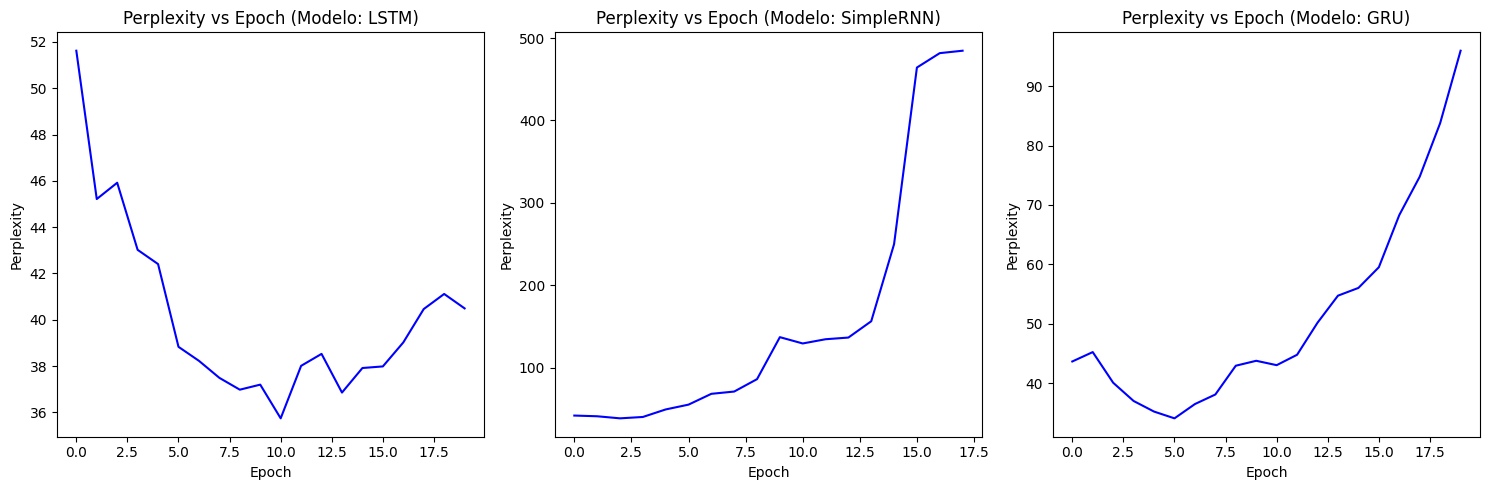

In [21]:
# Creamos subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Para el modelo LSTM
axs[0].plot(history_ppl_LSTM, color='blue')
axs[0].set_title('Perplexity vs Epoch (Modelo: LSTM)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Perplexity')

# Plara el modelo SimpleRNN
axs[1].plot(history_ppl_SimpleRNN, color='blue')
axs[1].set_title('Perplexity vs Epoch (Modelo: SimpleRNN)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Perplexity')

# Para el modelo GRU
axs[2].plot(history_ppl_GRU, color='blue')
axs[2].set_title('Perplexity vs Epoch (Modelo: GRU)')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Perplexity')

plt.tight_layout()
plt.show()

De los gráficos anteriores se observa que el mejor comportamiento se obtuvo con el modelo LSTM y este es el único modelo en el que los valores de perplejidad reducen a medida que las épocas se van ejecutando, si bien al final se ve un incremento.

Los peores resultados en cuanto a la perplejidad se obtienen con el modelo SimpleRNN, esto no solo porque los valores de perplejidad incrementan, sino tambien por que los valores llegan casi a 500. Si bien el modelo GRU tambien incrementa la perplejidad, los valores no sobrepasan de 100.

In [22]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_LSTM = keras.models.load_model('model_LSTM.keras')
model_simpleRNN = keras.models.load_model('model_SimpleRNN.keras')
model_GRU = keras.models.load_model('model_GRU.keras')

## Predicción de Próximo Caracter

Utilizamos la herramienta Gradio para disponibilizar una interfaz gráfica para la predicción del proximo caracter.

In [23]:
!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.6/436.6 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/

In [32]:
import gradio as gr

def model_response(human_text, model=model_simpleRNN):
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')
    y_pred = np.argmax(model.predict(encoded)[0,-1,:])

    out_word = ''
    out_word = idx2char[y_pred]
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c6305d297eb1fd9fc0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c6305d297eb1fd9fc0.gradio.live


In [36]:
print(f'Respuesta LSTM: { model_response("esa casa viej", model_LSTM) }')
print(f'Respuesta SimpleRNN: {model_response("esa casa viej", model_simpleRNN)}')
print(f'Respuesta GRU: {model_response("esa casa viej", model_GRU)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Respuesta LSTM: esa casa viejo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Respuesta SimpleRNN: esa casa viejo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Respuesta GRU: esa casa viejo


Se observa que la predicción del siguiente caracter tiene sentido, si bien el adjetivo "viejo" hace referencia a un sujeto masculino y el ejemplo habla de "la casa" que es un sujeto femenino, la palabra guarda coehrencia y corresponde a una palabra real.

## Generacion de Secuencias

In [26]:
def generate_seq(model, seed_text, max_length, n_words):
    output_text = seed_text

    for _ in range(n_words):
        encoded = [char2idx[ch] for ch in output_text.lower() ]
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
        out_word = ''
        out_word = idx2char[y_hat]
        output_text += out_word
    return output_text

In [38]:
input_text='Llevé a mis visitantes'

print('Modelo LSTM:')
print(generate_seq(model_LSTM, input_text, max_length=max_context_size, n_words=30))

print('Modelo Simple RNN:')
print(generate_seq(model_simpleRNN, input_text, max_length=max_context_size, n_words=30))

print('Modelo GRU:')
print(generate_seq(model_GRU, input_text, max_length=max_context_size, n_words=30))

Modelo LSTM:
Llevé a mis visitantes ente co la la la la la la la 
Modelo Simple RNN:
Llevé a mis visitantes 
 ento con ento en la pera e
Modelo GRU:
Llevé a mis visitantes entente con entente con enten


Se observa que las secuencias generadas, en general, no guardan mucha coherencia literaria para ninguno de los modelos, esto mas que nada porque los tres modelos generaron palabras inexistentes.

Se observa que el modelo LSTM termina generando la misma palabra una y otra vez.

## Beam Search y Muestreo Aleatorio

In [28]:
def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [29]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [30]:
lstm_sto_beamsearch = beam_search(model_LSTM, num_beams=10, num_words=20, input="lo primero que hice fue", temp=5, mode="sto")
print(f"model_LSTM (estocastico), temp=5: {decode(lstm_sto_beamsearch[0])}")

rnn_sto_beamsearch = beam_search(model_simpleRNN, num_beams=10, num_words=20, input="lo primero que hice fue", temp=5, mode="sto")
print(f"model_simpleRNN (estocastico), temp=5: {decode(rnn_sto_beamsearch[0])}")

gru_sto_beamsearch = beam_search(model_GRU, num_beams=10, num_words=20, input="lo primero que hice fue", temp=5, mode="sto")
print(f"model_GRU (estocastico), temp=5: {decode(gru_sto_beamsearch[0])}")

model_LSTM (estocastico), temp=5: lo primero que hice fue tín mnlimhe,tspú e(
model_simpleRNN (estocastico), temp=5: lo primero que hice fues íorartaanólclófdgz
model_GRU (estocastico), temp=5: lo primero que hice fue tigaesib(ú aúll paf


In [31]:
lstm_det_beamsearch = beam_search(model_LSTM, num_beams=10, num_words=5, input="lo primero que hice fue", mode="det")
print(f"model_LSTM (determinista), temp=5: {decode(lstm_det_beamsearch[0])}")

rnn_det_beamsearch = beam_search(model_simpleRNN, num_beams=10, num_words=5, input="lo primero que hice fue", mode="det")
print(f"model_simpleRNN (determinista), temp=5: {decode(rnn_det_beamsearch[0])}")

gru_det_beamsearch = beam_search(model_GRU, num_beams=10, num_words=5, input="lo primero que hice fue", mode="det")
print(f"model_GRU (determinista), temp=5: {decode(gru_det_beamsearch[0])}")

model_LSTM (determinista), temp=5: lo primero que hice fuenten 
model_simpleRNN (determinista), temp=5: lo primero que hice fue do e
model_GRU (determinista), temp=5: lo primero que hice fuentent


Luego de aplicar Beam Search se observa que los resultados son poco satisfactorios, dado que para los tres modelos, las palabras generadas son inesixtentes.

Sin embargo, y de forma similar a lo observado con los modelos de Tokenización por palabras, los resultados deterministas son ligeramente mejores, si bien siguen siendo palabras inexistentes.

## Conclusiones Finales

En este desafío se analizaron modelos de Tokenización por Caracteres utilizando tres diferentes arquitecturas. En general las observaciones son las siguientes:

En cuanto a la medición de la perplejidad, se observa que el modelo LSTM, presenta el mejor comportamiento en el que se puede apreciar que en efecto los valores de la perplejidad descienden. En contraste, el modelo SimpleRNN presento el peor comportamiento.

En cuanto a la predicción de caracteres, se observa que los tres modelos pudieron predecir de forma correcta el siguiente caracter, si bien hubo una pequeña incoherencia con el género del sujeto, lo cual dentro del contexto del idioma español conlleva importancia.

Acerca de la generación de secuencias, se observó resultados desfavorables para los tres modelos, con una ligera mejoría para el caso del Beam Search determinista.